This is a companion notebook for the book [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff). For readability, it only contains runnable code blocks and section titles, and omits everything else in the book: text paragraphs, figures, and pseudocode.

**If you want to be able to follow what's going on, I recommend reading the notebook side by side with your copy of the book.**

This notebook was generated for TensorFlow 2.6.

# Getting started with neural networks: Classification and regression

## Classifying movie reviews: A binary classification example

### The IMDB dataset

**Loading the IMDB dataset**

In [3]:
from tensorflow.keras.datasets import imdb#下載IMDB數據集
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(
    num_words=10000)#參數num_words=10000表示數據集保留了最常出現的10,000個單詞

In [4]:
train_data[0]#評論文本已轉換為整數數組，每個整數表示字典中的特定單詞。以下是第一篇評論文本轉換後的形式：

[1,
 14,
 22,
 16,
 43,
 530,
 973,
 1622,
 1385,
 65,
 458,
 4468,
 66,
 3941,
 4,
 173,
 36,
 256,
 5,
 25,
 100,
 43,
 838,
 112,
 50,
 670,
 2,
 9,
 35,
 480,
 284,
 5,
 150,
 4,
 172,
 112,
 167,
 2,
 336,
 385,
 39,
 4,
 172,
 4536,
 1111,
 17,
 546,
 38,
 13,
 447,
 4,
 192,
 50,
 16,
 6,
 147,
 2025,
 19,
 14,
 22,
 4,
 1920,
 4613,
 469,
 4,
 22,
 71,
 87,
 12,
 16,
 43,
 530,
 38,
 76,
 15,
 13,
 1247,
 4,
 22,
 17,
 515,
 17,
 12,
 16,
 626,
 18,
 2,
 5,
 62,
 386,
 12,
 8,
 316,
 8,
 106,
 5,
 4,
 2223,
 5244,
 16,
 480,
 66,
 3785,
 33,
 4,
 130,
 12,
 16,
 38,
 619,
 5,
 25,
 124,
 51,
 36,
 135,
 48,
 25,
 1415,
 33,
 6,
 22,
 12,
 215,
 28,
 77,
 52,
 5,
 14,
 407,
 16,
 82,
 2,
 8,
 4,
 107,
 117,
 5952,
 15,
 256,
 4,
 2,
 7,
 3766,
 5,
 723,
 36,
 71,
 43,
 530,
 476,
 26,
 400,
 317,
 46,
 7,
 4,
 2,
 1029,
 13,
 104,
 88,
 4,
 381,
 15,
 297,
 98,
 32,
 2071,
 56,
 26,
 141,
 6,
 194,
 7486,
 18,
 4,
 226,
 22,
 21,
 134,
 476,
 26,
 480,
 5,
 144,
 30,
 5535,
 18,

In [5]:
train_labels[1]

0

In [6]:
max([max(sequence) for sequence in train_data])


9999

In [7]:
#修改處
min([min(sequence) for sequence in train_data])

1

**Decoding reviews back to text**

In [8]:
#word_index 是一個將單詞映射爲整數索引的字典
word_index = imdb.get_word_index()
#鍵值顛倒，將整數索引映射爲單詞
reverse_word_index = dict(
    [(value, key) for (key, value) in word_index.items()])
#將評論解碼。注意，索引減去了 3，因爲 0、1、2是爲“padding”（填充）、
#“start of sequence”（序列開始）、“unknown”（未知詞）分別保留的索引
decoded_review = " ".join(
    [reverse_word_index.get(i - 3, "?") for i in train_data[0]])

### Preparing the data

**Encoding the integer sequences via multi-hot encoding**

In [9]:

#將整數序列編碼爲二進制矩陣
import numpy as np
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        for j in sequence:
            results[i, j] = 1.
    return results

In [10]:
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

In [11]:
x_train[0]

array([0., 1., 1., ..., 0., 0., 0.])

In [12]:
x_train.shape

(25000, 10000)

In [13]:
y_train = np.asarray(train_labels).astype("float32")
y_test = np.asarray(test_labels).astype("float32")

### Building your model

**Model definition**

In [14]:
#構建網絡
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Dense(16, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

2022-11-12 18:44:41.074573: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


**Compiling the model**

In [15]:
#設置模型的損失函數、優化器、評估標準
#優化器配置可以寫成字符串形式
#定義的第一個東西是optimizer,
#也就是說你要用什麼樣的方式來找最好的function，雖然optimizer後面可以皆不同的方式，
#但是這些不同的方式，其實都是gradient descent 類似的方法
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])

### Validating your approach

**Setting aside a validation set**

In [19]:
#取訓練集向量化後的數據x_train的前10000個數據  
x_val = x_train[:10000]# 餘下的數據
partial_x_train = x_train[10000:]
# 取訓練集向量化後的標籤one_hot_train_labels 的前10000個標籤
y_val = y_train[:10000]
partial_y_train = y_train[10000:]# 餘下的標籤

**Training your model**

In [20]:
#訓練模型
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Epoch 1/20
30/30 [==============================] - 2s 49ms/step - loss: 0.5440 - accuracy: 0.7743 - val_loss: 0.4116 - val_accuracy: 0.8621
Epoch 2/20
30/30 [==============================] - 1s 25ms/step - loss: 0.3264 - accuracy: 0.8981 - val_loss: 0.3275 - val_accuracy: 0.8784
Epoch 3/20
30/30 [==============================] - 1s 18ms/step - loss: 0.2329 - accuracy: 0.9265 - val_loss: 0.2857 - val_accuracy: 0.8865
Epoch 4/20
30/30 [==============================] - 1s 20ms/step - loss: 0.1839 - accuracy: 0.9413 - val_loss: 0.2815 - val_accuracy: 0.8872
Epoch 5/20
30/30 [==============================] - 1s 20ms/step - loss: 0.1495 - accuracy: 0.9521 - val_loss: 0.2818 - val_accuracy: 0.8865
Epoch 6/20
30/30 [==============================] - 1s 19ms/step - loss: 0.1190 - accuracy: 0.9649 - val_loss: 0.3035 - val_accuracy: 0.8833
Epoch 7/20
30/30 [==============================] - 1s 20ms/step - loss: 0.0996 - accuracy: 0.9710 - val_loss: 0.3060 - val_accuracy: 0.8841
Epoch 8/20
30

In [21]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

**Plotting the training and validation loss**

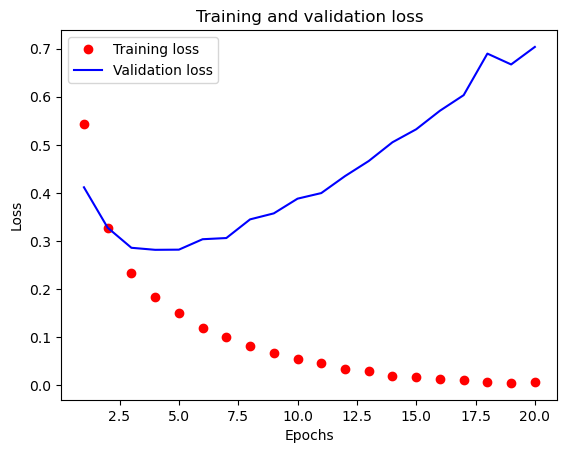

In [22]:
#繪製訓練損失和驗證損失
import matplotlib.pyplot as plt
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
#修正處由藍點點改成紅點點
plt.plot(epochs, loss_values, "ro", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

**Plotting the training and validation accuracy**

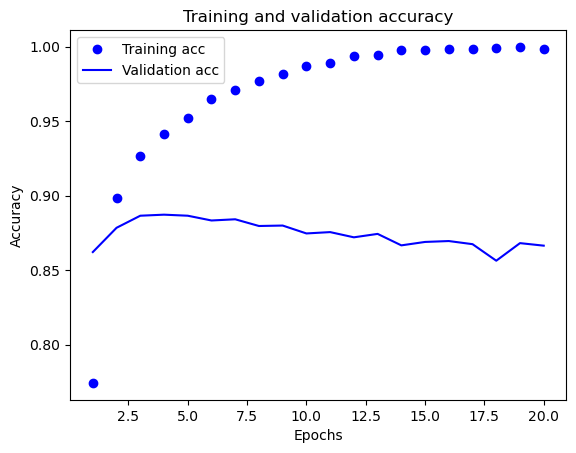

In [23]:
#繪製訓練精度和驗證精度
plt.clf()
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

**Retraining a model from scratch**

In [40]:
#重頭開始重新訓練一個模型
model = keras.Sequential([
    layers.Dense(64, activation="relu"),
    layers.Dense(64, activation="relu"),
    layers.Dense(1, activation="sigmoid")
    #sigmoid 函數就能使Y的範圍限制在[0,1]之間，中間只有一小段模糊地帶，適合用於二分法(真或偽)。
])
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])


In [41]:
#開始訓練你的Network，使用"fit"，就可以用Gradient Descent來訓練你的Network
#其中要給它你的訓練資料的輸入還有Label，
#"x_train"代表圖片，"y_train"代表Label，然後再設定Batch size以及Epochs的大小。
model.fit(x_train, y_train, epochs=9, batch_size=512)

Epoch 1/9
49/49 [==============================] - 1s 17ms/step - loss: 0.4245 - accuracy: 0.8066
Epoch 2/9
49/49 [==============================] - 1s 15ms/step - loss: 0.2400 - accuracy: 0.9068
Epoch 3/9
49/49 [==============================] - 1s 15ms/step - loss: 0.1787 - accuracy: 0.9335
Epoch 4/9
49/49 [==============================] - 1s 15ms/step - loss: 0.1528 - accuracy: 0.9420
Epoch 5/9
49/49 [==============================] - 1s 16ms/step - loss: 0.1151 - accuracy: 0.9580
Epoch 6/9
49/49 [==============================] - 1s 15ms/step - loss: 0.0831 - accuracy: 0.9709
Epoch 7/9
49/49 [==============================] - 1s 16ms/step - loss: 0.0637 - accuracy: 0.9784
Epoch 8/9
49/49 [==============================] - 1s 15ms/step - loss: 0.0452 - accuracy: 0.9864
Epoch 9/9
49/49 [==============================] - 1s 15ms/step - loss: 0.0320 - accuracy: 0.9903


In [42]:
#訓練好之後，你要拿這個model來做評估，意思就是說你實際上有測試資料的label，
#你只是想要知道你model在測試資料的表現如何，那就使用"evaluation"，
#只要把測試資料的圖片跟Label給它，它就會幫你計算你的model的正確率
results = model.evaluate(x_test, y_test)

782/782 [==============================] - 1s 1ms/step - loss: 0.5597 - accuracy: 0.8674


In [43]:
print(results)#得到約87%的精準度

[0.5596511363983154, 0.8673999905586243]


### Using a trained model to generate predictions on new data

In [45]:
#在新數據上生成預測結果
#概率最大的就是最有可能的分類
predictions = model.predict(x_test)
print(predictions[1].shape)# 查看predictions中的每個元素的shape
print(np.sum(predictions[1]))# 一個向量的1維概率總和
print(np.argmax(predictions[1]))# 最大的概率就是預測類別
#結果說明了：
#->

782/782 [==============================] - 1s 1ms/step
(1,)
0.9999996
0


### Further experiments

### Wrapping up

## Classifying newswires: A multiclass classification example

### The Reuters dataset

**Loading the Reuters dataset**

In [74]:
#本節使用路透社數據集，它包含許多短新聞及其對應的主題，由路透社在 1986 年發佈。
#它是一個簡單的、廣泛使用的文本分類數據集。它包括 46 個不同的主題：某些主題的樣本更多，但訓練集中每個主題都有至少 10 個樣本。
from tensorflow.keras.datasets import reuters
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(
    num_words=10000)


In [75]:
len(train_data)

8982

In [76]:
len(test_data)

2246

In [77]:
train_data[10]

[1,
 245,
 273,
 207,
 156,
 53,
 74,
 160,
 26,
 14,
 46,
 296,
 26,
 39,
 74,
 2979,
 3554,
 14,
 46,
 4689,
 4329,
 86,
 61,
 3499,
 4795,
 14,
 61,
 451,
 4329,
 17,
 12]

**Decoding newswires back to text**

In [78]:
word_index = reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
decoded_newswire = " ".join([reverse_word_index.get(i - 3, "?") for i in
    train_data[0]])
##注意，索引減去了 3，因爲 0、1、2 是爲“padding”（填充）、“start of sequence”（序列開始）、“unknown”（未知詞）分別保留的索引

In [79]:
train_labels[10]

3

### Preparing the data

**Encoding the input data**

In [80]:
## 將訓練數據、測試數據向量化
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

**Encoding the labels**

In [81]:
#準備數據(自定義one-hot方法)
def to_one_hot(labels, dimension=46):
    results = np.zeros((len(labels), dimension))
    for i, label in enumerate(labels):
        results[i, label] = 1.
    return results
y_train = to_one_hot(train_labels)
y_test = to_one_hot(test_labels)

In [82]:
#將標籤向量化（兩種方法：1.標籤列表轉換成整數張量 2.使用one-hot編碼）
#Keras 內置方法可以實現這個操作
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(train_labels)
y_test = to_categorical(test_labels)

### Building your model

**Model definition**

In [83]:
#構建網絡
model = keras.Sequential([
    layers.Dense(64, activation="relu"),
    layers.Dense(64, activation="relu"),
# 最後一層是大小爲46的Dense層意味着
# 對於每個輸入樣本，網絡都會輸出一個46維向量，這個向量的每個元素（即每個維度）代表不同的輸出類別
    layers.Dense(46, activation="softmax")
#softmax激活後的輸出可以理解成該概率分佈，概率總和爲1
])

**Compiling the model**

In [84]:
#編譯模型
model.compile(optimizer="rmsprop",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

### Validating your approach

**Setting aside a validation set**

In [85]:
#取訓練集向量化後的數據x_train的前1000個數據  
x_val = x_train[:1000]# 餘下的數據
partial_x_train = x_train[1000:]
# 取訓練集向量化後的標籤one_hot_train_labels 的前1000個標籤
y_val = y_train[:1000]
partial_y_train = y_train[1000:]# 餘下的標籤

**Training the model**

In [86]:
#訓練模型
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Epoch 1/20
16/16 [==============================] - 1s 30ms/step - loss: 2.6479 - accuracy: 0.4960 - val_loss: 1.7373 - val_accuracy: 0.6490
Epoch 2/20
16/16 [==============================] - 0s 17ms/step - loss: 1.4142 - accuracy: 0.7085 - val_loss: 1.3184 - val_accuracy: 0.7150
Epoch 3/20
16/16 [==============================] - 0s 17ms/step - loss: 1.0440 - accuracy: 0.7801 - val_loss: 1.1351 - val_accuracy: 0.7520
Epoch 4/20
16/16 [==============================] - 0s 18ms/step - loss: 0.8227 - accuracy: 0.8251 - val_loss: 1.0454 - val_accuracy: 0.7760
Epoch 5/20
16/16 [==============================] - 0s 17ms/step - loss: 0.6539 - accuracy: 0.8637 - val_loss: 0.9478 - val_accuracy: 0.8110
Epoch 6/20
16/16 [==============================] - 0s 16ms/step - loss: 0.5257 - accuracy: 0.8913 - val_loss: 0.9132 - val_accuracy: 0.8140
Epoch 7/20
16/16 [==============================] - 0s 17ms/step - loss: 0.4174 - accuracy: 0.9152 - val_loss: 0.9162 - val_accuracy: 0.8060
Epoch 8/20
16

**Plotting the training and validation loss**

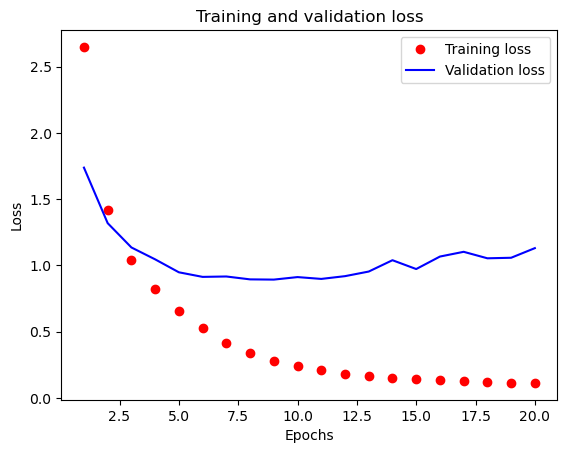

In [87]:
#繪製訓練損失和驗證損失
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, "ro", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

**Plotting the training and validation accuracy**

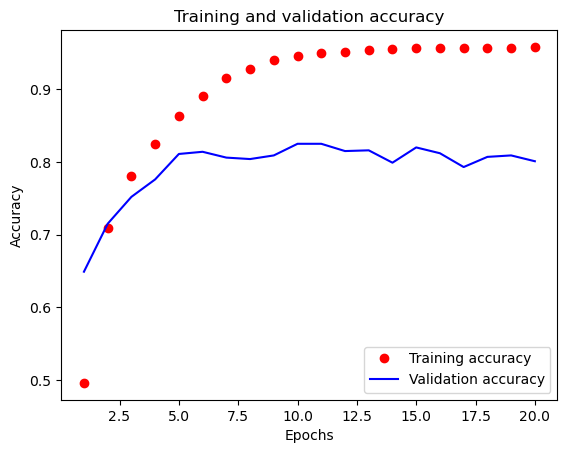

In [88]:
#繪製訓練精度和驗證精度
plt.clf()
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
plt.plot(epochs, acc, "ro", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

**Retraining a model from scratch**

In [89]:
#從頭開始重新訓練一個模型
#構建網絡
#這裏因爲輸出是46維，爲了防止信息瓶頸，每層的元素要多一些，這裏先選取爲64
#輸出層的激活函數選取softmax，這樣可以求取每個取值的概率，這裏一共46個概率且和爲1。
model = keras.Sequential([
  layers.Dense(64, activation="relu"),
  layers.Dense(64, activation="relu"),
  layers.Dense(46, activation="softmax")
])
model.compile(optimizer="rmsprop",
              loss="categorical_crossentropy",
              metrics=["accuracy"])
model.fit(x_train,
          y_train,
          epochs=10,
          batch_size=512)
results = model.evaluate(x_test, y_test)

Epoch 1/10
18/18 [==============================] - 1s 18ms/step - loss: 2.4083 - accuracy: 0.5078
Epoch 2/10
18/18 [==============================] - 0s 15ms/step - loss: 1.2912 - accuracy: 0.7174
Epoch 3/10
18/18 [==============================] - 0s 14ms/step - loss: 0.9666 - accuracy: 0.7926
Epoch 4/10
18/18 [==============================] - 0s 14ms/step - loss: 0.7582 - accuracy: 0.8382
Epoch 5/10
18/18 [==============================] - 0s 14ms/step - loss: 0.6052 - accuracy: 0.8732
Epoch 6/10
18/18 [==============================] - 0s 14ms/step - loss: 0.4836 - accuracy: 0.8984
Epoch 7/10
18/18 [==============================] - 0s 14ms/step - loss: 0.3923 - accuracy: 0.9182
Epoch 8/10
18/18 [==============================] - 0s 14ms/step - loss: 0.3187 - accuracy: 0.9304
Epoch 9/10
18/18 [==============================] - 0s 14ms/step - loss: 0.2714 - accuracy: 0.9387
Epoch 10/10
71/71 [==============================] - 0s 1ms/step - loss: 0.9838 - accuracy: 0.7988


In [90]:
results

[0.9838283658027649, 0.7987533211708069]

In [91]:
import copy
test_labels_copy = copy.copy(test_labels)
np.random.shuffle(test_labels_copy)
hits_array = np.array(test_labels) == np.array(test_labels_copy)
hits_array.mean()

0.19456812110418523

### Generating predictions on new data

In [92]:
#在新數據上生成預測結果
predictions = model.predict(x_test)

71/71 [==============================] - 0s 1ms/step


In [93]:
#在新數據上生成預測結果
predictions[0].shape

(46,)

In [94]:
#這個向量的所有元素總和爲 1。
np.sum(predictions[0])

1.0000001

In [95]:
#最大的元素就是預測類別，即概率最大的類別。
np.argmax(predictions[0])

3

### A different way to handle the labels and the loss

In [96]:
y_train = np.array(train_labels)
y_test = np.array(test_labels)

In [97]:
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

### The importance of having sufficiently large intermediate layers

**A model with an information bottleneck**

In [98]:
model = keras.Sequential([
    layers.Dense(64, activation="relu"),
    layers.Dense(4, activation="relu"),
    layers.Dense(46, activation="softmax")
])
model.compile(optimizer="rmsprop",
              loss="categorical_crossentropy",
              metrics=["accuracy"])
model.fit(partial_x_train,
          partial_y_train,
          epochs=20,
          batch_size=128,
          validation_data=(x_val, y_val))

Epoch 1/20
63/63 [==============================] - 1s 9ms/step - loss: 3.3354 - accuracy: 0.4509 - val_loss: 2.9921 - val_accuracy: 0.5200
Epoch 2/20
63/63 [==============================] - 0s 6ms/step - loss: 2.7584 - accuracy: 0.3723 - val_loss: 2.6779 - val_accuracy: 0.2850
Epoch 3/20
63/63 [==============================] - 0s 6ms/step - loss: 2.3757 - accuracy: 0.2924 - val_loss: 2.3286 - val_accuracy: 0.3010
Epoch 4/20
63/63 [==============================] - 0s 6ms/step - loss: 1.8720 - accuracy: 0.4528 - val_loss: 1.7686 - val_accuracy: 0.6390
Epoch 5/20
63/63 [==============================] - 0s 6ms/step - loss: 1.3445 - accuracy: 0.6802 - val_loss: 1.4842 - val_accuracy: 0.6530
Epoch 6/20
63/63 [==============================] - 0s 6ms/step - loss: 1.1703 - accuracy: 0.6991 - val_loss: 1.4820 - val_accuracy: 0.6640
Epoch 7/20
63/63 [==============================] - 0s 6ms/step - loss: 1.0915 - accuracy: 0.7212 - val_loss: 1.4542 - val_accuracy: 0.6790
Epoch 8/20
63/63 [==

### Further experiments

### Wrapping up

## Predicting house prices: A regression example

### The Boston Housing Price dataset

**Loading the Boston housing dataset**

In [99]:
#下載波士頓房價數據
#它包含的數據點相對較少，只有 506 個，分爲 404 個訓練樣本和 102 個測試樣本。
from tensorflow.keras.datasets import boston_housing
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

1，城鎮中非商業用地的比率

2，每塊面積25000英尺的地皮上，住宅用地的比率。

3，城鎮中非零售商業用地面積

4，是否沿河，1表示沿河，0表示不沿河

5，一氧化氮含量

6，住宅的平均單間數

7，1940年前自有產權房的數量

8，住宅與波士頓五個工作區的距離

9，接入高速公路的便利指數
10，每一萬美金所要繳納的全額房產稅

11，城鎮中的師生比

12，1000*(BK - 0.63)^2, BK表示黑人比率

13，底層人口的百分比







原文網址：https://kknews.cc/house/blbp9ym.html

In [100]:
train_data.shape
#訓練數據集只有404條,
#而每條數據集都包含以上13個方面的特徵



(404, 13)

In [101]:
test_data.shape
#測試數據集只有102條
#而每條數據集都包含以上13個方面的特徵

(102, 13)

In [102]:
#我們要預測的是自有產權房的中位價格，單位是千美元，我們看看訓練數據集對應的結果：
train_targets

array([15.2, 42.3, 50. , 21.1, 17.7, 18.5, 11.3, 15.6, 15.6, 14.4, 12.1,
       17.9, 23.1, 19.9, 15.7,  8.8, 50. , 22.5, 24.1, 27.5, 10.9, 30.8,
       32.9, 24. , 18.5, 13.3, 22.9, 34.7, 16.6, 17.5, 22.3, 16.1, 14.9,
       23.1, 34.9, 25. , 13.9, 13.1, 20.4, 20. , 15.2, 24.7, 22.2, 16.7,
       12.7, 15.6, 18.4, 21. , 30.1, 15.1, 18.7,  9.6, 31.5, 24.8, 19.1,
       22. , 14.5, 11. , 32. , 29.4, 20.3, 24.4, 14.6, 19.5, 14.1, 14.3,
       15.6, 10.5,  6.3, 19.3, 19.3, 13.4, 36.4, 17.8, 13.5, 16.5,  8.3,
       14.3, 16. , 13.4, 28.6, 43.5, 20.2, 22. , 23. , 20.7, 12.5, 48.5,
       14.6, 13.4, 23.7, 50. , 21.7, 39.8, 38.7, 22.2, 34.9, 22.5, 31.1,
       28.7, 46. , 41.7, 21. , 26.6, 15. , 24.4, 13.3, 21.2, 11.7, 21.7,
       19.4, 50. , 22.8, 19.7, 24.7, 36.2, 14.2, 18.9, 18.3, 20.6, 24.6,
       18.2,  8.7, 44. , 10.4, 13.2, 21.2, 37. , 30.7, 22.9, 20. , 19.3,
       31.7, 32. , 23.1, 18.8, 10.9, 50. , 19.6,  5. , 14.4, 19.8, 13.8,
       19.6, 23.9, 24.5, 25. , 19.9, 17.2, 24.6, 13

### Preparing the data

**Normalizing the data**

In [103]:
#準備數據
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std
test_data -= mean
test_data /= std

### Building your model

**Model definition**

In [104]:
#構建網絡
#我們構造的網絡最後一層只有一個節點，因為我們只需要預測一個結果，
#同時該節點沒有激活函數，當我們要預測的結果處於某個區間內時，我們就不用添加激活函數。
def build_model():
    # 因爲需要將同一個模型多次實例化，所以用一個函數來構建模型
    model = keras.Sequential([
        layers.Dense(64, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(1)
    ])
    #mse損失函數->均方誤差
    model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
    return model

### Validating your approach using K-fold validation

**K-fold validation**

In [105]:
#利用k折驗證來驗證方法
k = 4#4折
num_val_samples = len(train_data) // k#每折多少個樣本
num_epochs = 100
all_scores = []
for i in range(k):
    print(f"Processing fold #{i}")
    # 準備驗證數據：第 k 個分區的數據
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    #把剩下的k-1分數據作為訓練數據,如果第i分數據作為校驗數據
    #那麼把前i-1份和第i份之後的數據連起來
    # 準備訓練數據：其他所有分區的數據
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    # B構建 Keras 模型（已編譯）
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)
    model = build_model()
    ##把分割好的訓練數據和校驗數據輸入網絡
    # 訓練模型（靜默模式，verbose=0）
    model.fit(partial_train_data, partial_train_targets,
              epochs=num_epochs, batch_size=16, verbose=0)
    # 在驗證數據上評估模型
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3


In [106]:
print(all_scores)

[2.0822300910949707, 2.46872615814209, 2.358109474182129, 2.389162063598633]


In [107]:
#這就是 K 折交叉驗證的關鍵
#結果顯示：我們的預測結果跟正確結果相比大概相差2.4*1000也就是2400美元左右
#這個誤差還是過大
np.mean(all_scores)

2.3245569467544556

**Saving the validation logs at each fold**

In [112]:
#保存每折的驗證結果
num_epochs = 200#上面代碼把每次訓練的循環次數提高到200(原本是100)
all_mae_histories = []
for i in range(k):
    print(f"Processing fold #{i}")
    # 準備驗證數據：第 k 個分區的數據
    #依次把k分數據中的每一份作為校驗數據集
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    # 準備訓練數據：其他所有分區的數據
    #把剩下的k-1分數據作為訓練數據,
    #如果第i分數據作為校驗數據，那麼把前i-1份和第i份之後的數據連起來
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)
    # 構建 Keras 模型（已編譯）
    model = build_model()
    # 訓練模型（靜默模式，verbose=0）
    #把分割好的訓練數據和校驗數據輸入網絡
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=16, verbose=0)
    mae_history = history.history["val_mae"]
    all_mae_histories.append(mae_history)

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3


**Building the history of successive mean K-fold validation scores**

In [115]:
#計算所有輪次中的 K 折驗證分數平均值
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]
print(average_mae_history)

[19.072736740112305, 15.432039737701416, 11.02989387512207, 7.409159183502197, 5.705422878265381, 4.703874826431274, 4.034332752227783, 3.6469700932502747, 3.4588592648506165, 3.342967391014099, 3.1927132606506348, 3.036598563194275, 2.987482786178589, 2.8888267278671265, 2.8387349247932434, 2.8466996550559998, 2.7810433506965637, 2.7779454588890076, 2.715695858001709, 2.74452006816864, 2.6323975920677185, 2.6996864676475525, 2.598804771900177, 2.605792462825775, 2.633880615234375, 2.589200973510742, 2.5430321097373962, 2.5695452094078064, 2.5500301718711853, 2.570415496826172, 2.505028247833252, 2.51026850938797, 2.5067285895347595, 2.4812766909599304, 2.481610953807831, 2.4536441564559937, 2.4792760610580444, 2.4710274934768677, 2.4200215935707092, 2.4062426686286926, 2.4306470155715942, 2.373054623603821, 2.4084708094596863, 2.381546676158905, 2.396716296672821, 2.401243180036545, 2.420666515827179, 2.3931673169136047, 2.348822057247162, 2.378851681947708, 2.3438608646392822, 2.3030

**Plotting validation scores**

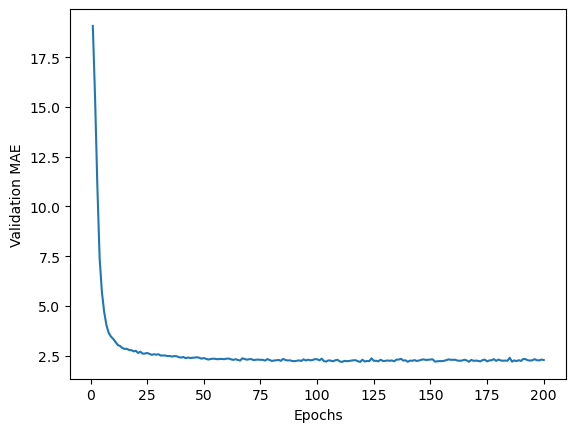

In [114]:
#繪製驗證分數
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()
#從上圖看到，前10個數據點誤差值存有巨大的差異，因此統計時要忽略掉這些點，
#後面的數據段誤差值變動很劇烈，但我們從圖中很難看出不同點之間的差異究竟是多少。



**Plotting validation scores, excluding the first 10 data points**

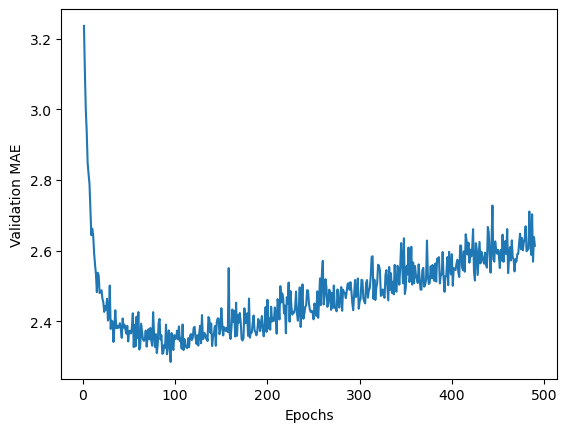

In [58]:


truncated_mae_history = average_mae_history[10:]
plt.plot(range(1, len(truncated_mae_history) + 1), truncated_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

**Training the final model**

In [117]:
#重新再訓練模型
model = build_model()
model.fit(train_data, train_targets,
          epochs=130, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

4/4 [==============================] - 0s 863us/step - loss: 20.9849 - mae: 2.9928


In [118]:
test_mae_score
#上面代碼運行後，得到的結果為2.86,也就是說，我們模型對測試數據中位數的預測誤差在2860作用
#由於測試數據的中位值在5000多，因此這個誤差還是比較大，主要原因在於數據量過小的原因



2.992760419845581

### Generating predictions on new data

In [61]:
predictions = model.predict(test_data)
predictions[0]

4/4 [==============================] - 0s 1ms/step


array([8.37303], dtype=float32)

### Wrapping up

## Summary